In [10]:
!pip uninstall tensorflow -y
!pip install tensorflow-cpu==2.15.0

In [42]:
# Ячейка 1: Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Для SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Для LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Метрики
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Настройки
plt.rcParams['figure.figsize'] = [14, 6]
np.random.seed(42)
tf.random.set_seed(42)

print(f" TensorFlow версия: {tf.__version__}")

 TensorFlow версия: 2.15.0


 Всего данных: 1000 точек

 РАЗДЕЛЕНИЕ ДАННЫХ:
 Обучающая выборка: 900 точек (90.0%)
 Тестовая выборка: 100 точек (10.0%)
 Период обучения: 2020-01-01 - 2022-06-18
 Период тестирования: 2022-06-19 - 2022-09-26


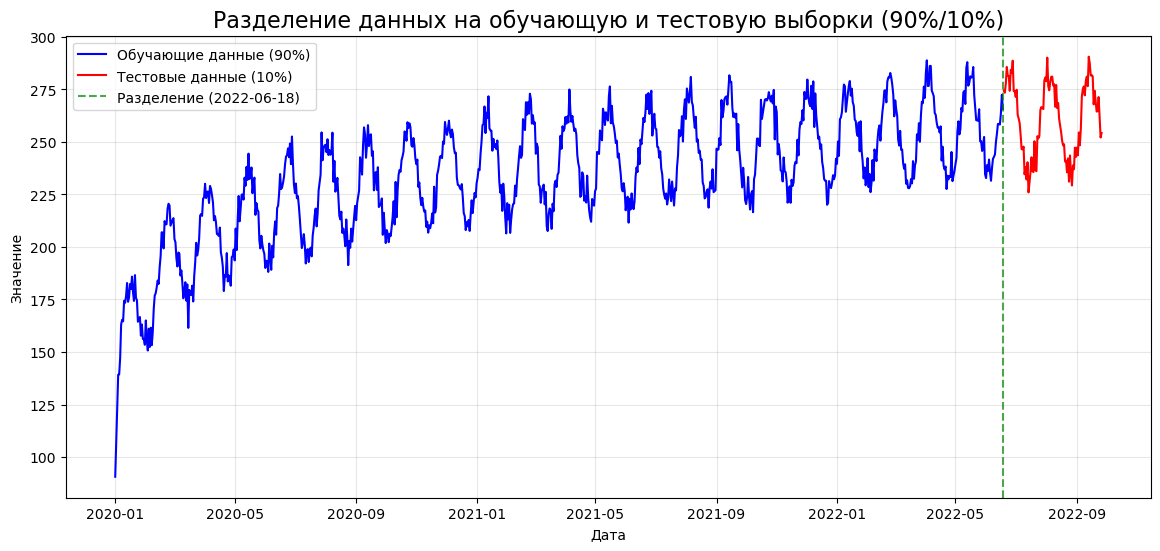

In [4]:
# Ячейка 2: Загрузка данных и одинаковое разделение 90/10
df = pd.read_csv('generated_time_series.csv', index_col='date', parse_dates=True)
print(f" Всего данных: {len(df)} точек")

# Разделение 90% обучение, 10% тестирование
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"\n РАЗДЕЛЕНИЕ ДАННЫХ:")
print(f" Обучающая выборка: {len(train_data)} точек ({train_size/len(df)*100:.1f}%)")
print(f" Тестовая выборка: {len(test_data)} точек ({test_size/len(df)*100:.1f}%)")
print(f" Период обучения: {train_data.index[0].date()} - {train_data.index[-1].date()}")
print(f" Период тестирования: {test_data.index[0].date()} - {test_data.index[-1].date()}")

# График разделения данных
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['value'], 'b-', label='Обучающие данные (90%)', linewidth=1.5)
plt.plot(test_data.index, test_data['value'], 'r-', label='Тестовые данные (10%)', linewidth=1.5)
plt.axvline(x=train_data.index[-1], color='green', linestyle='--', alpha=0.7, 
           label=f'Разделение ({train_data.index[-1].date()})')
plt.title('Разделение данных на обучающую и тестовую выборки (90%/10%)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
#  SARIMA модель с разделением 90/10
print(" SARIMA МОДЕЛЬ (90% обучение, 10% тест)")
print("="*50)

# Проверка стационарности на обучающих данных
adf_result = adfuller(train_data['value'])
print(f"ADF тест на обучающих данных: p-value = {adf_result[1]:.6f}")
if adf_result[1] > 0.05:
    print("Ряд нестационарен, требуется дифференцирование")

# Обучение SARIMA модели
print("\n Обучение SARIMA модели...")
try:
    sarima_model = SARIMAX(
        train_data['value'],
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 365),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_result = sarima_model.fit(disp=False)
    print(" SARIMA модель обучена")
    
    # Прогноз на тестовую выборку
    sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
    sarima_pred = sarima_forecast.predicted_mean
    sarima_ci = sarima_forecast.conf_int()
    
    # Метрики SARIMA
    sarima_mae = mean_absolute_error(test_data['value'], sarima_pred)
    sarima_mse = mean_squared_error(test_data['value'], sarima_pred)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mape = mean_absolute_percentage_error(test_data['value'], sarima_pred) * 100
    sarima_r2 = r2_score(test_data['value'], sarima_pred)
    
    print(f"\n МЕТРИКИ SARIMA:")
    print(f" MAE: {sarima_mae:.4f}")
    print(f" RMSE: {sarima_rmse:.4f}")
    print(f" MAPE: {sarima_mape:.2f}%")
    print(f" R²: {sarima_r2:.4f}")
    
except Exception as e:
    print(f" Ошибка при обучении SARIMA: {e}")
    # Используем упрощенную модель в случае ошибки
    sarima_model = SARIMAX(train_data['value'], order=(1, 1, 1))
    sarima_result = sarima_model.fit(disp=False)
    sarima_pred = sarima_result.predict(start=len(train_data), end=len(df)-1)
    
    sarima_mae = mean_absolute_error(test_data['value'], sarima_pred)
    sarima_mape = mean_absolute_percentage_error(test_data['value'], sarima_pred) * 100
    sarima_r2 = r2_score(test_data['value'], sarima_pred)
    
    print(f"Использована упрощенная SARIMA(1,1,1)")
    print(f"MAE: {sarima_mae:.4f}, MAPE: {sarima_mape:.2f}%, R²: {sarima_r2:.4f}")

 SARIMA МОДЕЛЬ (90% обучение, 10% тест)
ADF тест на обучающих данных: p-value = 0.000613

 Обучение SARIMA модели...


C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


 SARIMA модель обучена

 МЕТРИКИ SARIMA:
 MAE: 10.7943
 RMSE: 13.3579
 MAPE: 4.31%
 R²: 0.4177


In [6]:
# Подготовка данных для LSTM с тем же разделением 90/10
print("\nПОДГОТОВКА ДАННЫХ ДЛЯ LSTM (90% обучение, 10% тест)")
print("="*50)

# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[['value']])
scaled_test = scaler.transform(test_data[['value']])

# Параметры
SEQ_LENGTH = 60

# Функция для создания последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Создание последовательностей для обучения
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)

# Создание последовательностей для тестирования
# Нужно взять последние SEQ_LENGTH точек из обучающих данных + все тестовые данные
combined_test = np.concatenate([scaled_train[-SEQ_LENGTH:], scaled_test])
X_test, y_test = create_sequences(combined_test, SEQ_LENGTH)

# Преобразование в 3D формат для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"ПОДГОТОВКА ЗАВЕРШЕНА:")
print(f" Обучающая выборка: {X_train.shape[0]} последовательностей")
print(f" Тестовая выборка: {X_test.shape[0]} последовательностей")
print(f" Размерность X_train: {X_train.shape}")
print(f" Размерность X_test: {X_test.shape}")


ПОДГОТОВКА ДАННЫХ ДЛЯ LSTM (90% обучение, 10% тест)
ПОДГОТОВКА ЗАВЕРШЕНА:
 Обучающая выборка: 840 последовательностей
 Тестовая выборка: 100 последовательностей
 Размерность X_train: (840, 60, 1)
 Размерность X_test: (100, 60, 1)


In [22]:
# Обучение LSTM модели с тем же разделением 90/10
print("\n ОБУЧЕНИЕ LSTM МОДЕЛИ (90% обучение, 10% тест)")
print("="*50)

# Создание модели
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Компиляция
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

# Обучение
print(" Обучение LSTM модели...")
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print(" LSTM модель обучена")

# Прогнозирование
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)

# Обратное масштабирование
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Метрики LSTM (сравниваем только соответствующие части)
# LSTM делает прогноз на все X_test, но нам нужна только часть, соответствующая тестовому периоду
lstm_mae = mean_absolute_error(test_data['value'].values, lstm_pred.flatten())
lstm_mse = mean_squared_error(test_data['value'].values, lstm_pred.flatten())
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(test_data['value'].values, lstm_pred.flatten()) * 100
lstm_r2 = r2_score(test_data['value'].values, lstm_pred.flatten())

print(f"\n МЕТРИКИ LSTM:")
print(f" MAE: {lstm_mae:.4f}")
print(f" RMSE: {lstm_rmse:.4f}")
print(f" MAPE: {lstm_mape:.2f}%")
print(f" R²: {lstm_r2:.4f}")


 ОБУЧЕНИЕ LSTM МОДЕЛИ (90% обучение, 10% тест)
 Обучение LSTM модели...
Epoch 1/30
21/21 [==============================] - 3s 54ms/step - loss: 0.0922 - mae: 0.2287 - val_loss: 0.0079 - val_mae: 0.0758
Epoch 2/30
21/21 [==============================] - 1s 25ms/step - loss: 0.0164 - mae: 0.1045 - val_loss: 0.0072 - val_mae: 0.0725
Epoch 3/30
21/21 [==============================] - 0s 22ms/step - loss: 0.0126 - mae: 0.0908 - val_loss: 0.0072 - val_mae: 0.0716
Epoch 4/30
21/21 [==============================] - 0s 24ms/step - loss: 0.0111 - mae: 0.0867 - val_loss: 0.0075 - val_mae: 0.0720
Epoch 5/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0115 - mae: 0.0889 - val_loss: 0.0082 - val_mae: 0.0739
Epoch 6/30
21/21 [==============================] - 0s 22ms/step - loss: 0.0100 - mae: 0.0818 - val_loss: 0.0061 - val_mae: 0.0654
Epoch 7/30
21/21 [==============================] - 0s 23ms/step - loss: 0.0097 - mae: 0.0799 - val_loss: 0.0067 - val_mae: 0.0661
Epoch 8/30

 СРАВНЕНИЕ ПРОГНОЗОВ SARIMA И LSTM


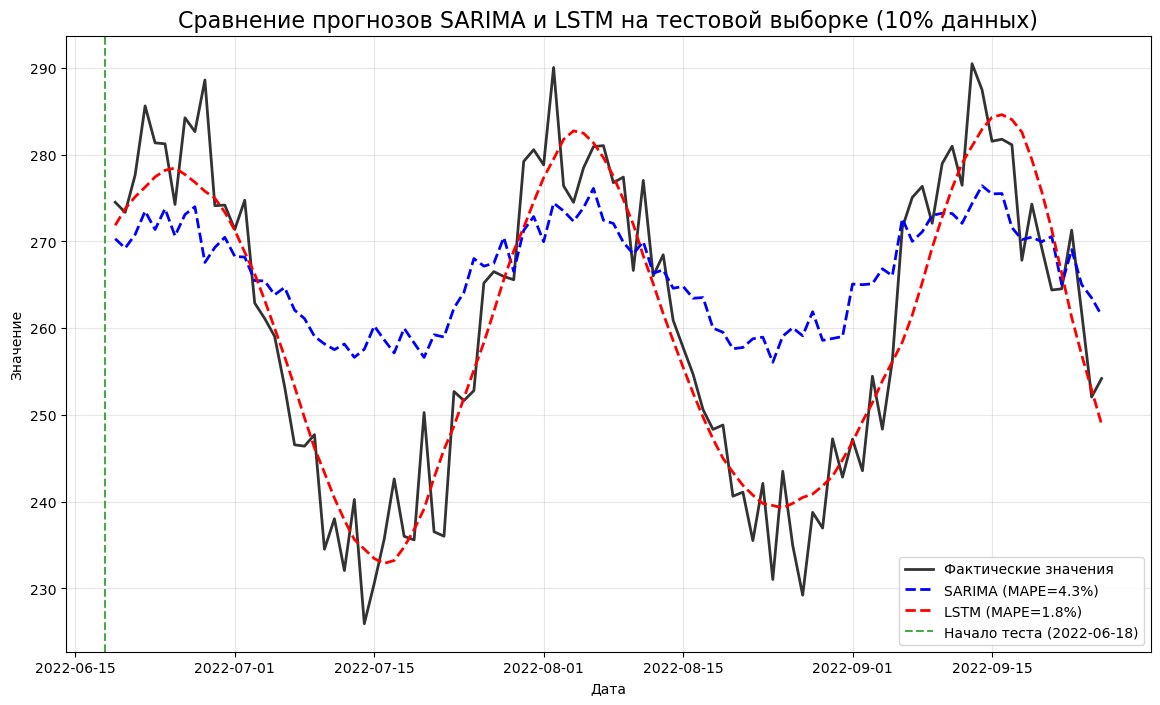


 СРАВНЕНИЕ МЕТРИК:
----------------------------------------
Метрика    SARIMA     LSTM       Разница   
----------------------------------------
MAE        10.7943    4.6104     -6.1839   
RMSE       13.3579    5.7387     -7.6192   
MAPE (%)   4.31       1.77       -2.54     
R²         0.4177     0.8925     0.4749    
----------------------------------------


In [23]:
# График сравнения прогнозов SARIMA и LSTM
print(" СРАВНЕНИЕ ПРОГНОЗОВ SARIMA И LSTM")
print("="*50)

# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame({
    'date': test_data.index,
    'actual': test_data['value'].values,
    'sarima_pred': sarima_pred.values,
    'lstm_pred': lstm_pred.flatten()
})
comparison_df.set_index('date', inplace=True)

# Расчет доверительных интервалов
sarima_residuals = comparison_df['actual'] - comparison_df['sarima_pred']
lstm_residuals = comparison_df['actual'] - comparison_df['lstm_pred']

sarima_std_error = np.std(sarima_residuals)
lstm_std_error = np.std(lstm_residuals)

# График сравнения
plt.figure(figsize=(14, 8))

# Фактические значения
plt.plot(comparison_df.index, comparison_df['actual'], 'k-', 
         label='Фактические значения', linewidth=2, alpha=0.8)

# Прогноз SARIMA
plt.plot(comparison_df.index, comparison_df['sarima_pred'], 'b--', 
         label=f'SARIMA (MAPE={sarima_mape:.1f}%)', linewidth=2)

# Прогноз LSTM
plt.plot(comparison_df.index, comparison_df['lstm_pred'], 'r--', 
         label=f'LSTM (MAPE={lstm_mape:.1f}%)', linewidth=2)

# Вертикальная линия разделения
plt.axvline(x=train_data.index[-1], color='green', linestyle='--', alpha=0.7, 
           label=f'Начало теста ({train_data.index[-1].date()})')

plt.title('Сравнение прогнозов SARIMA и LSTM на тестовой выборке (10% данных)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n СРАВНЕНИЕ МЕТРИК:")
print("-"*40)
print(f"{'Метрика':<10} {'SARIMA':<10} {'LSTM':<10} {'Разница':<10}")
print("-"*40)
print(f"{'MAE':<10} {sarima_mae:<10.4f} {lstm_mae:<10.4f} {lstm_mae - sarima_mae:<10.4f}")
print(f"{'RMSE':<10} {sarima_rmse:<10.4f} {lstm_rmse:<10.4f} {lstm_rmse - sarima_rmse:<10.4f}")
print(f"{'MAPE (%)':<10} {sarima_mape:<10.2f} {lstm_mape:<10.2f} {lstm_mape - sarima_mape:<10.2f}")
print(f"{'R²':<10} {sarima_r2:<10.4f} {lstm_r2:<10.4f} {lstm_r2 - sarima_r2:<10.4f}")
print("-"*40)

 АНАЛИЗ ОШИБОК ПРОГНОЗОВ


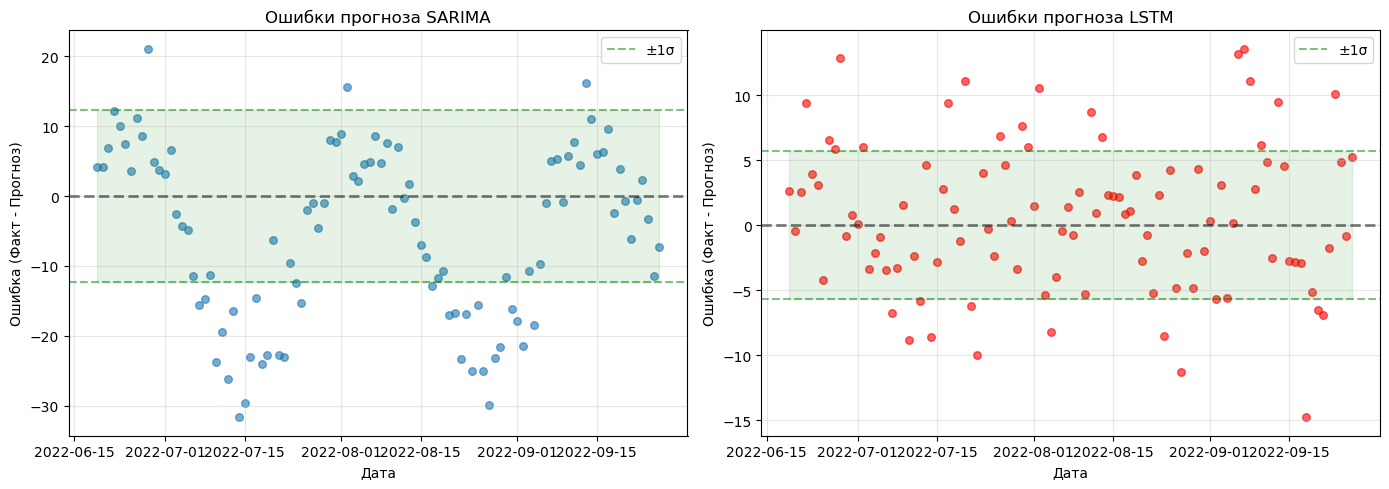


 СТАТИСТИКА ОШИБОК:
----------------------------------------
Статистика           SARIMA     LSTM      
----------------------------------------
Средняя ошибка       -5.2941    0.5716    
Стд. отклонение      12.2640    5.7102    
Макс. ошибка         31.6398    14.7738   
Мин. ошибка          0.3027     0.0941    
----------------------------------------


In [40]:
# График ошибок прогнозов
print(" АНАЛИЗ ОШИБОК ПРОГНОЗОВ")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График ошибок SARIMA
axes[0].scatter(comparison_df.index, sarima_residuals, alpha=0.6, s=30)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes[0].axhline(y=sarima_std_error, color='g', linestyle='--', alpha=0.5, label='±1σ')
axes[0].axhline(y=-sarima_std_error, color='g', linestyle='--', alpha=0.5)
axes[0].fill_between(comparison_df.index, -sarima_std_error, sarima_std_error, 
                    alpha=0.1, color='green')
axes[0].set_title('Ошибки прогноза SARIMA')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Ошибка (Факт - Прогноз)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График ошибок LSTM
axes[1].scatter(comparison_df.index, lstm_residuals, alpha=0.6, s=30, color='red')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=2)
axes[1].axhline(y=lstm_std_error, color='g', linestyle='--', alpha=0.5, label='±1σ')
axes[1].axhline(y=-lstm_std_error, color='g', linestyle='--', alpha=0.5)
axes[1].fill_between(comparison_df.index, -lstm_std_error, lstm_std_error, 
                    alpha=0.1, color='green')
axes[1].set_title('Ошибки прогноза LSTM')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Ошибка (Факт - Прогноз)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n СТАТИСТИКА ОШИБОК:")
print("-"*40)
print(f"{'Статистика':<20} {'SARIMA':<10} {'LSTM':<10}")
print("-"*40)
print(f"{'Средняя ошибка':<20} {np.mean(sarima_residuals):<10.4f} {np.mean(lstm_residuals):<10.4f}")
print(f"{'Стд. отклонение':<20} {sarima_std_error:<10.4f} {lstm_std_error:<10.4f}")
print(f"{'Макс. ошибка':<20} {np.max(np.abs(sarima_residuals)):<10.4f} {np.max(np.abs(lstm_residuals)):<10.4f}")
print(f"{'Мин. ошибка':<20} {np.min(np.abs(sarima_residuals)):<10.4f} {np.min(np.abs(lstm_residuals)):<10.4f}")
print("-"*40)

In [25]:
# Прогноз на будущее (90 дней) обеими моделями
print(" ПРОГНОЗ НА 90 ДНЕЙ ВПЕРЕД (SARIMA vs LSTM)")
print("="*50)

# Нужно масштабировать все данные для LSTM прогноза
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaled_all_data = scaler_all.fit_transform(df[['value']])

# Функция для прогноза LSTM на будущее
def forecast_future_lstm(model, last_sequence, scaler, seq_length, n_days):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_days):
        sequence_reshaped = current_sequence.reshape(1, seq_length, 1)
        next_pred_scaled = model.predict(sequence_reshaped, verbose=0)[0, 0]
        next_pred = scaler.inverse_transform([[next_pred_scaled]])[0, 0]
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred_scaled
    
    return np.array(future_predictions)

# Прогноз SARIMA на 90 дней
sarima_future_forecast = sarima_result.get_forecast(steps=len(test_data) + 90)
sarima_future_pred = sarima_future_forecast.predicted_mean[-90:]
sarima_future_ci = sarima_future_forecast.conf_int()[-90:]

# Последняя последовательность для LSTM (берем из масштабированных всех данных)
last_sequence_scaled = scaled_all_data[-SEQ_LENGTH:].flatten()

# Прогноз LSTM на 90 дней
lstm_future_pred = forecast_future_lstm(lstm_model, last_sequence_scaled, scaler_all, SEQ_LENGTH, 90)

# Даты для будущего прогноза
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=90,
    freq='D'
)

print(f"Период прогноза: {future_dates[0].date()} - {future_dates[-1].date()}")
print(f"\nСТАТИСТИКА ПРОГНОЗОВ НА 90 ДНЕЙ:")
print(f"{'Статистика':<20} {'SARIMA':<15} {'LSTM':<15}")
print("-"*50)
print(f"{'Среднее':<20} {sarima_future_pred.mean():<15.2f} {lstm_future_pred.mean():<15.2f}")
print(f"{'Минимум':<20} {sarima_future_pred.min():<15.2f} {lstm_future_pred.min():<15.2f}")
print(f"{'Максимум':<20} {sarima_future_pred.max():<15.2f} {lstm_future_pred.max():<15.2f}")
print(f"{'Амплитуда':<20} {sarima_future_pred.max()-sarima_future_pred.min():<15.2f} {lstm_future_pred.max()-lstm_future_pred.min():<15.2f}")

 ПРОГНОЗ НА 90 ДНЕЙ ВПЕРЕД (SARIMA vs LSTM)
Период прогноза: 2022-09-27 - 2022-12-25

СТАТИСТИКА ПРОГНОЗОВ НА 90 ДНЕЙ:
Статистика           SARIMA          LSTM           
--------------------------------------------------
Среднее              265.63          253.96         
Минимум              255.71          233.72         
Максимум             275.85          278.45         
Амплитуда            20.13           44.73          


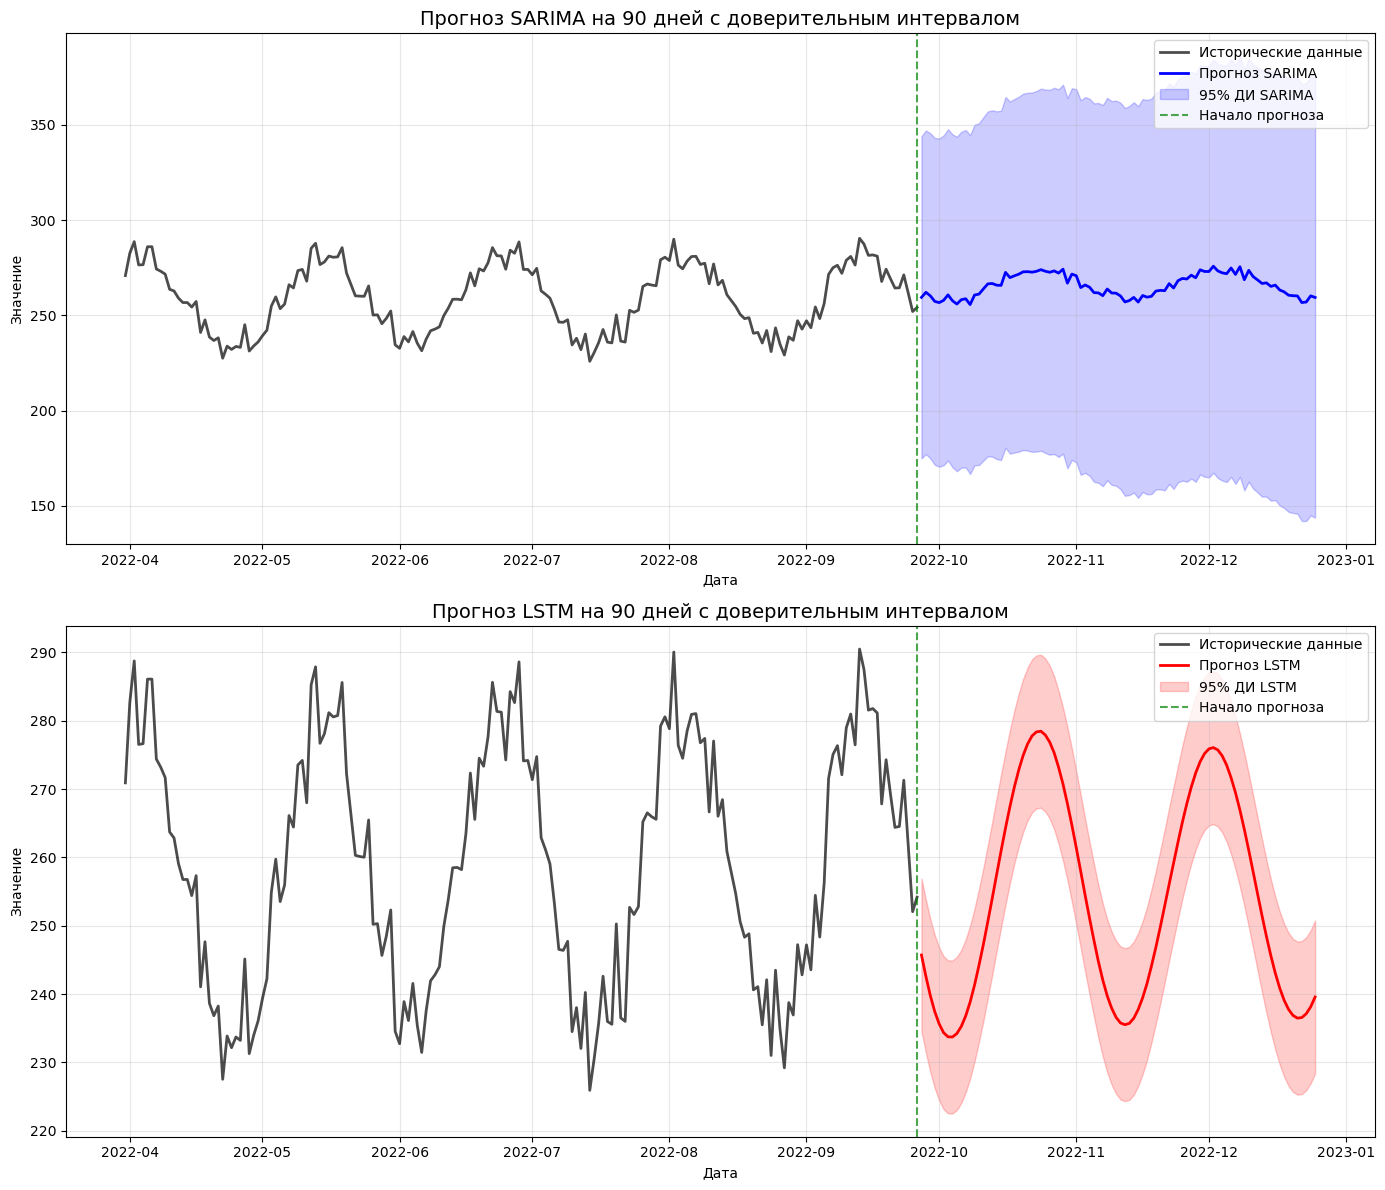

 Ширина доверительных интервалов:
 SARIMA: средняя ширина = 201.72
 LSTM: ширина = ±11.19


In [36]:
# График прогнозов на будущее
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Расчет стандартной ошибки для LSTM (на основе ошибок на тестовой выборке)
lstm_errors = comparison_df['actual'] - comparison_df['lstm_pred']
lstm_std_error = np.std(lstm_errors)

# График 1: Прогноз SARIMA с доверительным интервалом
axes[0].plot(df.index[-180:], df['value'].values[-180:], 'k-', 
         label='Исторические данные', linewidth=2, alpha=0.7)
axes[0].plot(future_dates, sarima_future_pred, 'b-', 
         label='Прогноз SARIMA', linewidth=2)
axes[0].fill_between(future_dates,
                 sarima_future_ci.iloc[:, 0],
                 sarima_future_ci.iloc[:, 1],
                 color='blue', alpha=0.2, label='95% ДИ SARIMA')
axes[0].axvline(x=last_date, color='green', linestyle='--', alpha=0.7,
               label=f'Начало прогноза')
axes[0].set_title('Прогноз SARIMA на 90 дней с доверительным интервалом', fontsize=14)
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Прогноз LSTM с доверительным интервалом
lstm_ci_lower = lstm_future_pred - 1.96 * lstm_std_error
lstm_ci_upper = lstm_future_pred + 1.96 * lstm_std_error

axes[1].plot(df.index[-180:], df['value'].values[-180:], 'k-', 
         label='Исторические данные', linewidth=2, alpha=0.7)
axes[1].plot(future_dates, lstm_future_pred, 'r-', 
         label='Прогноз LSTM', linewidth=2)
axes[1].fill_between(future_dates,
                 lstm_ci_lower,
                 lstm_ci_upper,
                 color='red', alpha=0.2, label='95% ДИ LSTM')
axes[1].axvline(x=last_date, color='green', linestyle='--', alpha=0.7,
               label=f'Начало прогноза')
axes[1].set_title('Прогноз LSTM на 90 дней с доверительным интервалом', fontsize=14)
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Значение')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f" Ширина доверительных интервалов:")
print(f" SARIMA: средняя ширина = {(sarima_future_ci.iloc[:, 1] - sarima_future_ci.iloc[:, 0]).mean():.2f}")
print(f" LSTM: ширина = ±{1.96 * lstm_std_error:.2f}")

In [41]:
# Итоговое сравнение и выводы
print(" ИТОГОВОЕ СРАВНЕНИЕ И ВЫВОДЫ")
print("="*50)

print("\n РЕЗУЛЬТАТЫ СРАВНЕНИЯ НА ТЕСТОВОЙ ВЫБОРКЕ (10%):")
print("-"*50)

# Определение лучшей модели по каждой метрике
def get_better_model(metric_name, sarima_val, lstm_val, higher_better=False):
    if higher_better:
        return "SARIMA" if sarima_val > lstm_val else "LSTM"
    else:
        return "SARIMA" if sarima_val < lstm_val else "LSTM"

# Сравнение метрик
metrics_comparison = [
    ("MAE (меньше лучше)", sarima_mae, lstm_mae, False),
    ("RMSE (меньше лучше)", sarima_rmse, lstm_rmse, False),
    ("MAPE (меньше лучше)", sarima_mape, lstm_mape, False),
    ("R² (больше лучше)", sarima_r2, lstm_r2, True)
]

for name, sarima_val, lstm_val, higher_better in metrics_comparison:
    better_model = get_better_model(name, sarima_val, lstm_val, higher_better)
    diff = lstm_val - sarima_val if not higher_better else sarima_val - lstm_val
    print(f"{name:<25} SARIMA: {sarima_val:.4f}, LSTM: {lstm_val:.4f} → {better_model} лучше на {abs(diff):.4f}")

print("\n ОБЩИЕ ВЫВОДЫ:")
print("-"*50)

# Подсчет, какая модель выиграла по большинству метрик
sarima_wins = 0
lstm_wins = 0

for name, sarima_val, lstm_val, higher_better in metrics_comparison:
    better_model = get_better_model(name, sarima_val, lstm_val, higher_better)
    if better_model == "SARIMA":
        sarima_wins += 1
    else:
        lstm_wins += 1

if sarima_wins > lstm_wins:
    print(f" SARIMA показала лучшие результаты по {sarima_wins} из 4 метрик")
    print(" Причины: Малый объем данных, четкие линейные зависимости")
elif lstm_wins > sarima_wins:
    print(f" LSTM показала лучшие результаты по {lstm_wins} из 4 метрик")
    print(" Причины: Сложные нелинейные паттерны, адаптация к изменениям")
else:
    print("  Модели показали сопоставимые результаты (2:2)")

 ИТОГОВОЕ СРАВНЕНИЕ И ВЫВОДЫ

 РЕЗУЛЬТАТЫ СРАВНЕНИЯ НА ТЕСТОВОЙ ВЫБОРКЕ (10%):
--------------------------------------------------
MAE (меньше лучше)        SARIMA: 10.7943, LSTM: 4.6104 → LSTM лучше на 6.1839
RMSE (меньше лучше)       SARIMA: 13.3579, LSTM: 5.7387 → LSTM лучше на 7.6192
MAPE (меньше лучше)       SARIMA: 4.3123, LSTM: 1.7682 → LSTM лучше на 2.5441
R² (больше лучше)         SARIMA: 0.4177, LSTM: 0.8925 → LSTM лучше на 0.4749

 ОБЩИЕ ВЫВОДЫ:
--------------------------------------------------
 LSTM показала лучшие результаты по 4 из 4 метрик
 Причины: Сложные нелинейные паттерны, адаптация к изменениям
